In [38]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définition des chemins des dossiers train et test
DATASET_DIR = "C:/Users/emnad/Downloads/dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")
CLASSES = ["Bulletin_de_soin", "Ordonnance", "Other"]
IMG_SIZE = 224  # Taille standard pour MobileNetV2

def load_images_from_folder(folder):
    X, y = [], []
    for label, category in enumerate(CLASSES):
        folder_path = os.path.join(folder, category)
        
        if not os.path.exists(folder_path):
            print(f"Dossier non trouvé : {folder_path}")
            continue
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Impossible de lire l'image : {img_path}")
                continue
            
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalisation
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

# Chargement des images depuis train et test
X_train, y_train = load_images_from_folder(TRAIN_DIR)
X_test, y_test = load_images_from_folder(TEST_DIR)

# Vérification finale
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Les images n'ont pas été correctement chargées. Vérifie les chemins et le format des images.")


In [39]:
from sklearn.model_selection import train_test_split

# Division du train en 80% train et 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# Vérification des tailles
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 2514, Validation: 280, Test: 700


In [40]:
# Chargement du modèle pré-entraîné
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # On freeze les poids

# Ajout des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(3, activation="softmax")(x)  # 3 neurones pour 3 classes

# Création du modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# model.summary()


In [41]:
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.2, horizontal_flip=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)


C:\Users\emnad\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.7987 - loss: 0.4693 - val_accuracy: 0.9500 - val_loss: 0.1756
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 410ms/step - accuracy: 0.9294 - loss: 0.1840 - val_accuracy: 0.9571 - val_loss: 0.1528
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.9543 - loss: 0.1326 - val_accuracy: 0.9536 - val_loss: 0.1480
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 409ms/step - accuracy: 0.9582 - loss: 0.1379 - val_accuracy: 0.9679 - val_loss: 0.1146
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 408ms/step - accuracy: 0.9649 - loss: 0.1122 - val_accuracy: 0.9714 - val_loss: 0.1084
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 412ms/step - accuracy: 0.9642 - loss: 0.1080 - val_accuracy: 0.9357 - val_loss: 0.1699
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 425ms/step - accuracy: 0.9592 - loss: 0.1148 - val_accuracy: 0.9286 - val_loss: 0.1919
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 418ms/step - accuracy: 0.9592 - loss: 0.1327 - val_accu

In [47]:
model.save("document_classifier.h5")


In [48]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("document_classifier.h5")



In [49]:
def predict_image(image_path, model, X_test, y_test):
    IMG_SIZE = 224  # Taille utilisée lors de l'entraînement

    # Chargement et prétraitement de l'image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalisation
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension b111111atch

    # Prédiction
    predictions = model.predict(img)[0]  # Liste des probabilités pour chaque classe
    class_index = np.argmax(predictions)  # Récupérer l'index de la classe avec la plus haute probabilité
    confidence = predictions[class_index] * 100

    # Correspondance avec les classes
    class_labels = ["bulletin de soin", "ordonnance", "autre document médical"]
    class_label = class_labels[class_index]

    # 🔹 **Calcul de l'accuracy globale du modèle**
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"Prédiction : {class_label} | Confiance : {confidence:.2f}%")
    print(f"Accuracy globale du modèle sur test : {accuracy * 100:.2f}%")



In [52]:
predict_image(r"C:\Users\emnad\Downloads\dataPI\ordonnance\28.jpg", model, X_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prédiction : ordonnance | Confiance : 99.56%
Accuracy globale du modèle sur test : 94.86%


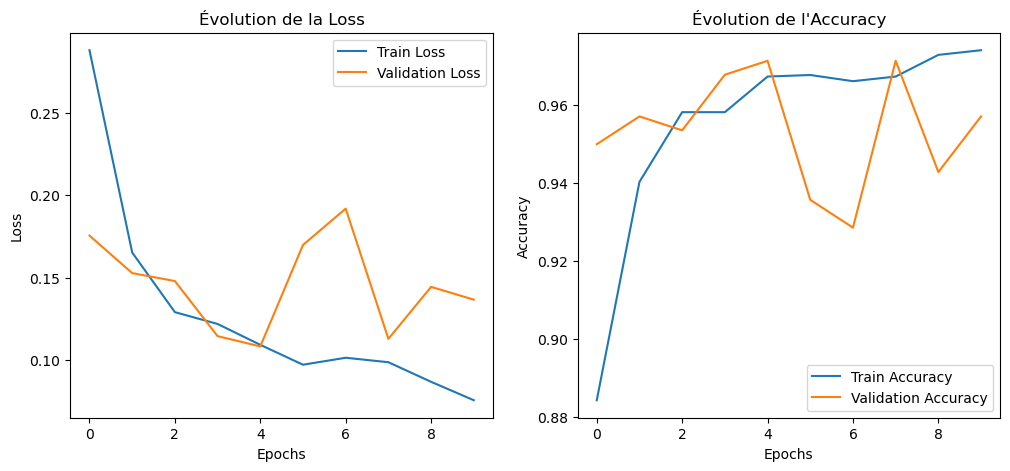

In [42]:
import matplotlib.pyplot as plt

# Récupérer l'historique
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Tracer la perte (loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution de la Loss")

# Tracer l'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Évolution de l'Accuracy")

plt.show()
